<a href="https://colab.research.google.com/github/kotiksrex/Numpy-and-Pandas/blob/project_rf_model/%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_rf_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Курсовой проект - прогнозирование цен на недвижимость**

Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

Исследование целевой переменной: распределение и т.д.
1. Обзор количественных переменных и подсчет основных статистик по ним
2. Обзор категориальных переменных и статистики по ним

3. Обработка пропусков
4. Обработка выбросов
5. Отбор и построение новых признаков
6. Оптимизация памяти уже в готовом датасете
7. Подготовка классов и функций для обработки данных в модели

Загрузка данных
#Описание датасета

**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района
**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

In [72]:
import numpy as np
import pandas as pd
import random
import pytest
import math

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
#from catboost import Pool, CatBoost, CatBoostClassifier, CatBoostRegressor, CatboostError

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler



# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
matplotlib.rcParams.update({'font.size': 14})

In [76]:
train_df = pd.read_csv('train.csv', sep=',')
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


In [77]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [78]:
train_df.columns


Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [79]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [80]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

##**Оптимизация памяти**

In [81]:
def reduce_mem_usage(train_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_df.columns:
        col_type = train_df[col].dtype
        
        if col_type != object:
            c_min = train_df[col].min()
            c_max = train_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_df[col] = train_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_df[col] = train_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_df[col] = train_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_df[col] = train_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_df[col] = train_df[col].astype(np.float32)
                else:
                    train_df[col] = train_df[col].astype(np.float64)
        #else:
            #train_df[col] = train_df[col].as_ordered('category')

    end_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train_df

In [82]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.80 MB
Decreased by 47.5%


##**EDA** - Exploratory Data Analysis
1. Исследование целевой переменной: распределение и т.д.
2. Обзор количественных переменных и подсчет основных статистик по ним
3. Обзор категориальных переменных и статистики по ним

4. Обработка пропусков
5. Обработка выбросов
6. Отбор и построение новых признаков
7. Оптимизация памяти уже в готовом датасете
8. Подготовка классов и функций для обработки данных в модели

Проверяем распределение целевой переменной, считаем основные статистики. Логарифмируем и проверяем еще раз распределение. 
PS: не разобралась как это использовать, кроме как выбрать медианные значения при создании новых признаков.

In [83]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

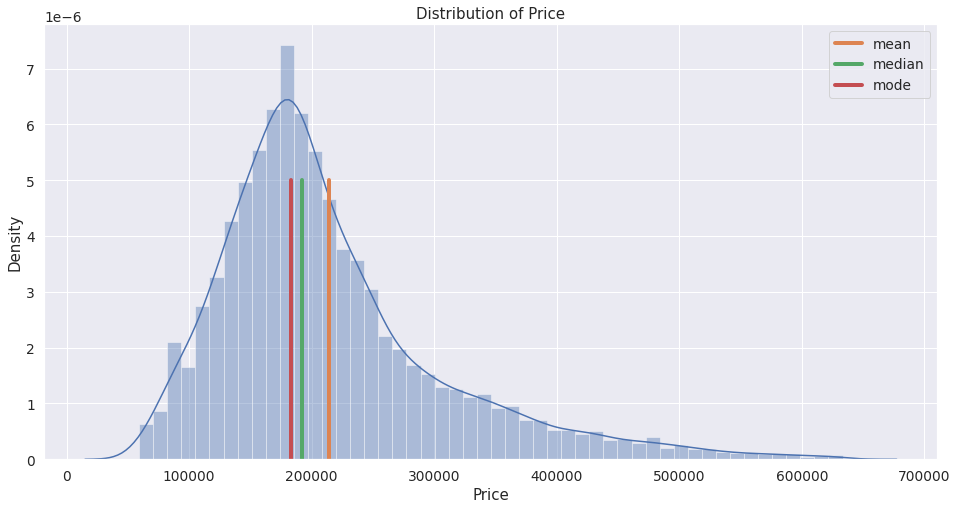

In [84]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

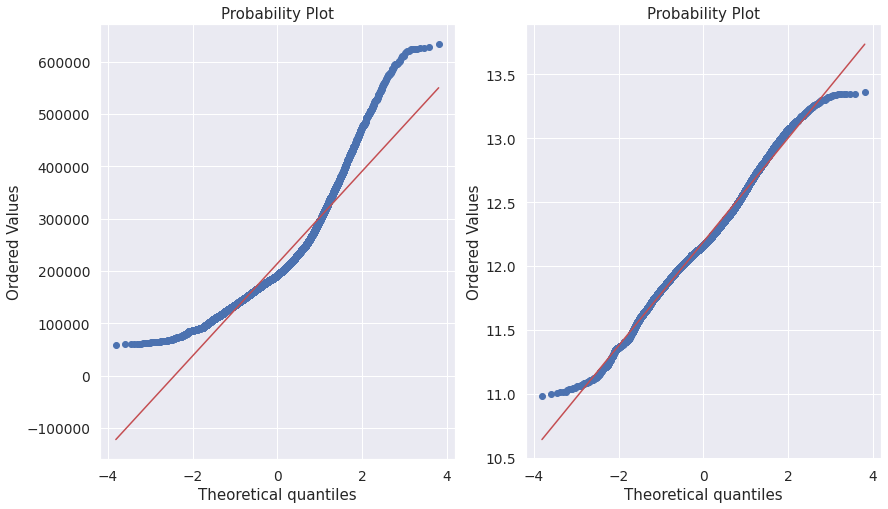

In [85]:
from scipy import stats 

fig = plt.figure(figsize = (14,8))
fig.add_subplot(1,2,1)
res = stats.probplot(train_df['Price'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train_df['Price']), plot=plt)

#Посмотрим какие признаки относятся к количественнам, а какие к категориальным

In [86]:
train_df.select_dtypes(include='int64').columns.tolist()

[]

In [87]:
train_df.select_dtypes(include='float64').columns.tolist()

[]

In [88]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [89]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [90]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [91]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [92]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [93]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Анализ зависимости частот встречаемости по двум признакам Ecology показал, что в данных нет пересечений типа АА. Т.о. можно либо ввести дамми переменные, либо сгенерировать новый признак с 3-мя категориями АВ, ВА, ВВ и присвоить им номера 1, 2, 3 соответственно. Также категориальные переменные можно использовать для создания новых признаков (Feature Target Encoding - кодирование целевого значения через любые другие признаки). 

%pylab inline
# figsize(5, 3)
ct = pd.crosstab([train_df.Ecology_2], [train_df.Ecology_3])
ct.plot(kind='bar')
ct.T.plot(kind='bar', stacked=True, figsize=(5, 3))
ct

Поскольку пропусков в категориальных переменных нет, переходим к изучению количественных переменных.

Теперь создадим матрицу коррляций признаков с таргетом

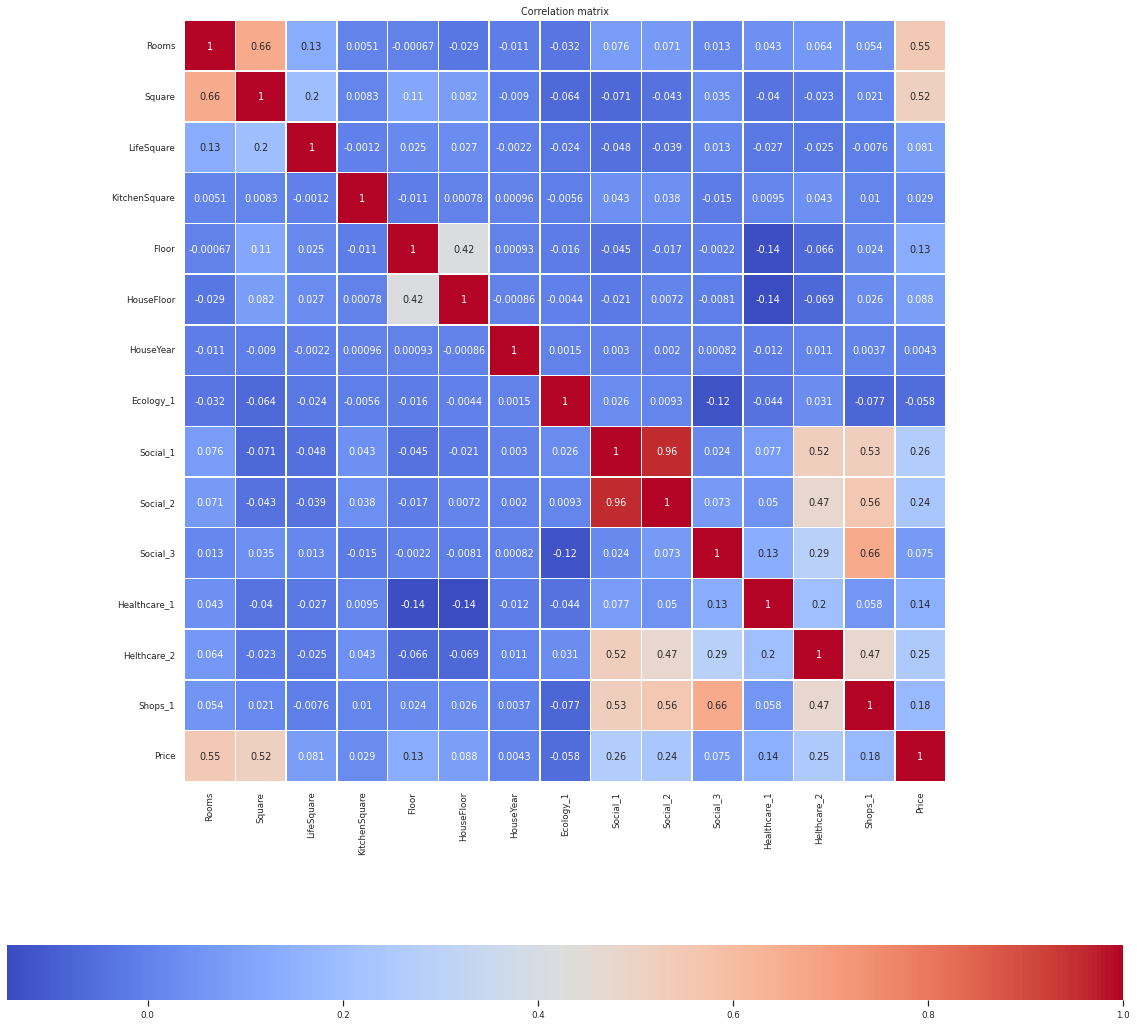

In [94]:
corrmatrix = train_df.corr()
plt.figure(figsize = (20,20))
sns.set(font_scale=0.8)
#corrmatrix[np.abs(corrmatrix) < 0.1] = 0

sns.heatmap(corrmatrix, annot=True, linewidths=.5, cmap='coolwarm', square=True, cbar_kws= {'orientation': 'horizontal'})

plt.title('Correlation matrix')
plt.show()

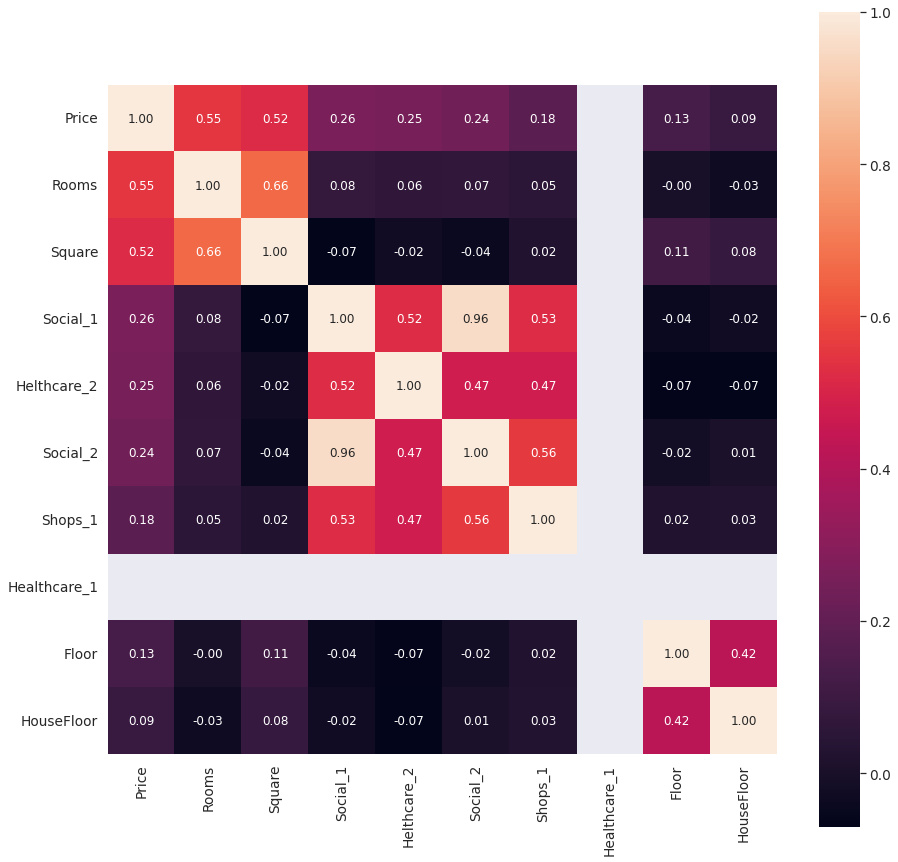

In [95]:
k = 10 # количество коррелирующих признаков, которое мы хотим увидеть
plt.figure(figsize = (15,15))
cols = corrmatrix.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Как и ожидалось, целевая переменная(Price - стоимость недвижимости) в первую очередь зависит от площади и количества комнат. Эти признаки положительно коррелируют между собой (0,66). Возможно имеет смысл объединить их в один с целью преодоления проблемы мультиколлинеарности в данных. В дополнительной обработке нуждаются признаки, описывающие распределение площади внутри квартиры. По жилой площади очень много пропусков в данных. 
Самая высокая положительная корреляция обнаружена между признаками Social 1 и Social_2 (0,96). Корреляция этих признаков с Healthcare_2  и Shops_1 (от 0,47 до 0,56).
Не логичным кажется очень низкий вклад местоположения квартир. Вероятно это связано с большим количеством категорий в данном признаке. 

Переходим к обработке пропусков и выбросов в количественных переменных.
 

#Обнаруженные проблемы в данных
DistrictId - слишком много категорий

'Ecology_2', 'Ecology_3', 'Shops_2' - несбалансированные выборки, особенно Ecology_2.  Проверить зависимость частот встречаемости.

Проверим пропуски

In [96]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

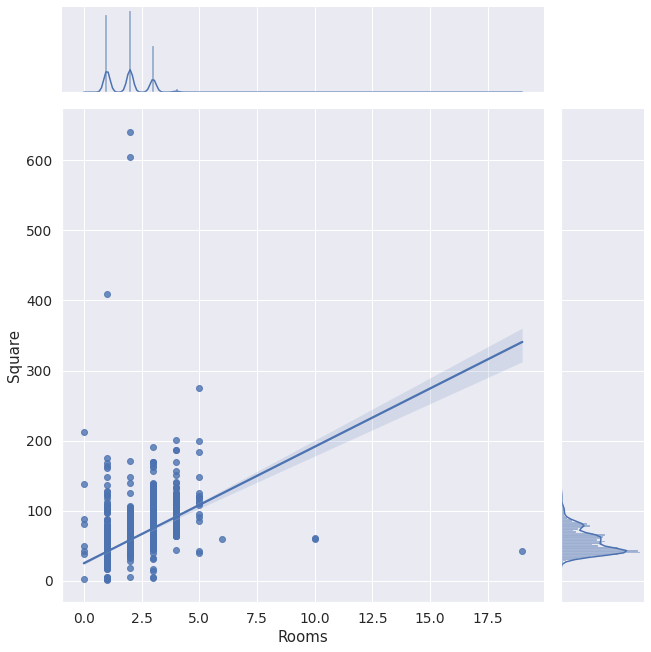

In [97]:
grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)

plt.show()

График распределения стоимости квартиры, в зависимотси от количества комнат позволяет сделать следующие выводы:
1. Объекты из выборки с 0 значениями имеют большой разброс по стоимости. Поэтому это либо студии, стоимость которых сильно меняется в зависимости от других факторов. Либо это все-таки объекты с разным количеством комнат. 
2. Единственный объект с 19-тью комнатами имеет стоимость ниже средней по выборке.
3. Два объекта с 10-тью комнатами имеют стоимость близкую к среднему или медианному значению. 
Учитывая то, что точечные замены стоимости в тренировочном датасете неприемлимы, считаю логичным использовать подход замены описанных выше выбросов на медианное значение.

Сначала пометим в выборке те значения, которые собираемся заменить. 
Затем проведем замену на медиану. 

Дальнейшая тренировка моделей показала, что лучшим вариантом замены для нулевого количества комнат будет 1.

In [98]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [99]:
#метод .loc для выбора по условию
train_df['Rooms_outlier'] = 0
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


##**Square** (площадь квартиры)


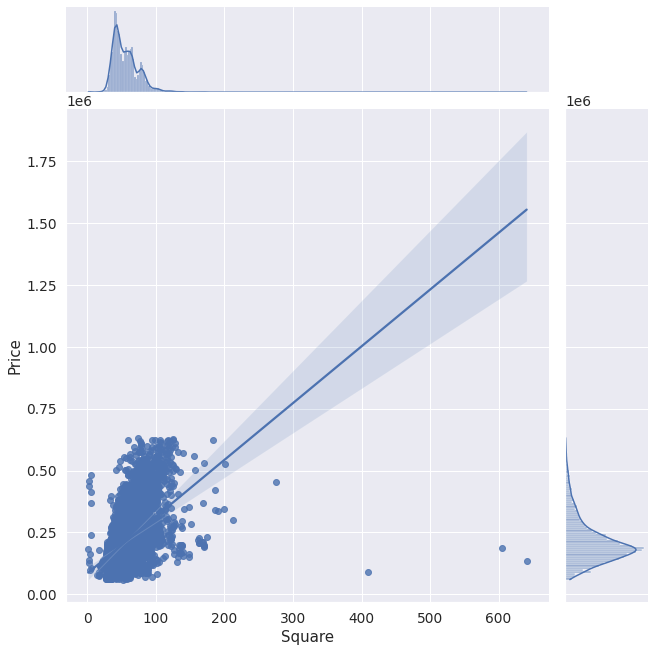

In [100]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)

plt.show()

Согласно данным с сайта циан, минимальная квартира-студия имеет площадь 13,4 кв метра. студии с площадью менее 20 кв.м. достаточно часто попадаются в объявлениях по продаже или аренде. Объект с наибольшей площадью -561 кв. метр. Огромные квартиры, скорее, исключение.  Т.о. можно выбрать "мягкие границы" от 15 до 250 для обработки выбросов.Заменим на медиану.

В ходе тестированиия моделей оказалось, что лучше в этом признаке выбросы ничем не заменять.

##**Helthcare_2**
*Курсив*

In [101]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

 Мы видим, что это порядковая переменная (разновидность категориальной). Следует ввести дамми-переменные и создать 6 новых признаков. Или использовать частотное кодирование. Используем второй вариант на этапе формирования новых признаков.

##**Helthcare_1** (много пропусков)

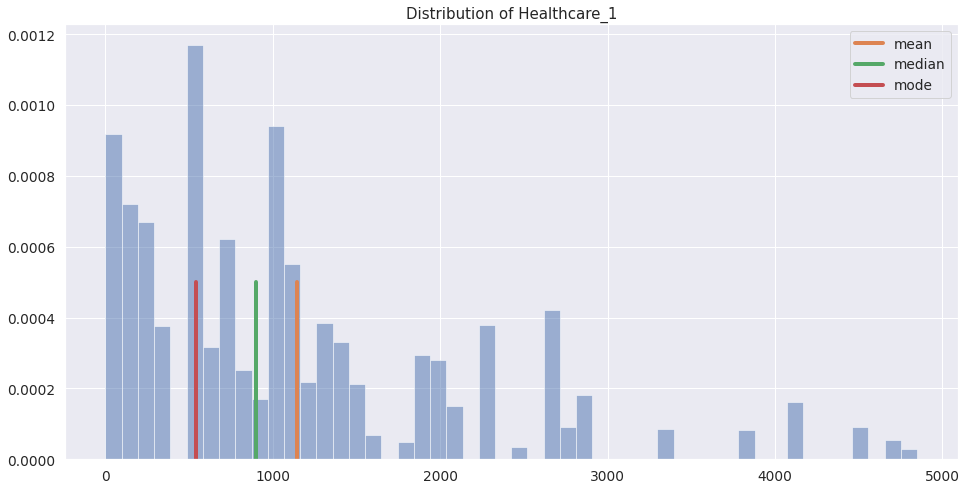

In [102]:
target_mean = round(train_df['Healthcare_1']).mean()
target_median = train_df['Healthcare_1'].median()
target_mode = train_df['Healthcare_1'].mode()[0]

plt.figure(figsize = (16, 8))
plt.hist(train_df['Healthcare_1'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.0005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Healthcare_1')
plt.legend()
plt.show()

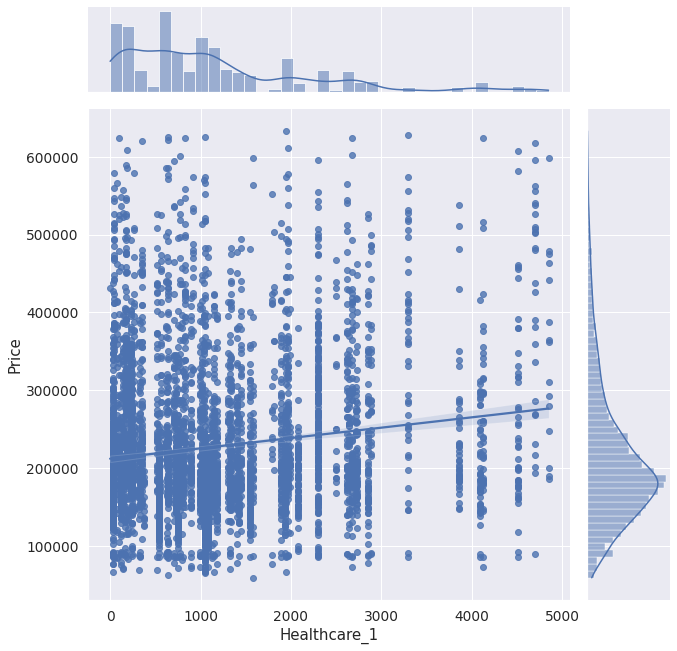

In [103]:
grid = sns.jointplot(train_df['Healthcare_1'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)

plt.show()

Для замены пропусков есть два варианта: замена на среднее или медиану и создание дополнительной бинарной переменной.

Создадим вспомогательный признак и заполним его 0, если пропуска в Healthcare_1 нет и 1, когда пропуски есть - это будет сделано сразу в классе!

##**Ecology_1**


In [104]:
train_df['Ecology_1'].value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.012522      1
0.014334      1
Name: Ecology_1, Length: 129, dtype: int64

In [105]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

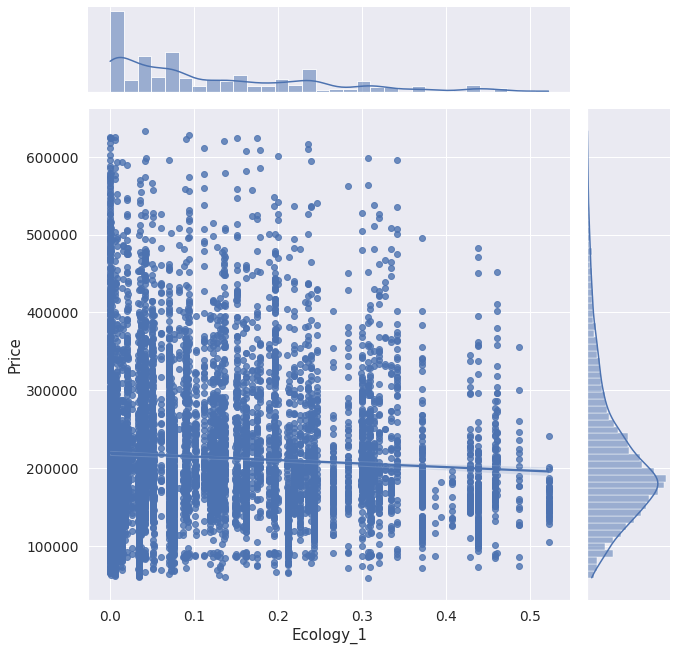

In [106]:
grid = sns.jointplot(train_df['Ecology_1'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)

plt.show()

##**Social_1**

In [107]:
train_df['Social_1'].value_counts()

2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
37    205
24    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

Это порядковый признак (много категорий). Применим частотное кодирование на этапе формирования новых признаков.

##**Social_2**

In [108]:
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

In [109]:
train_df['Social_2'].describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

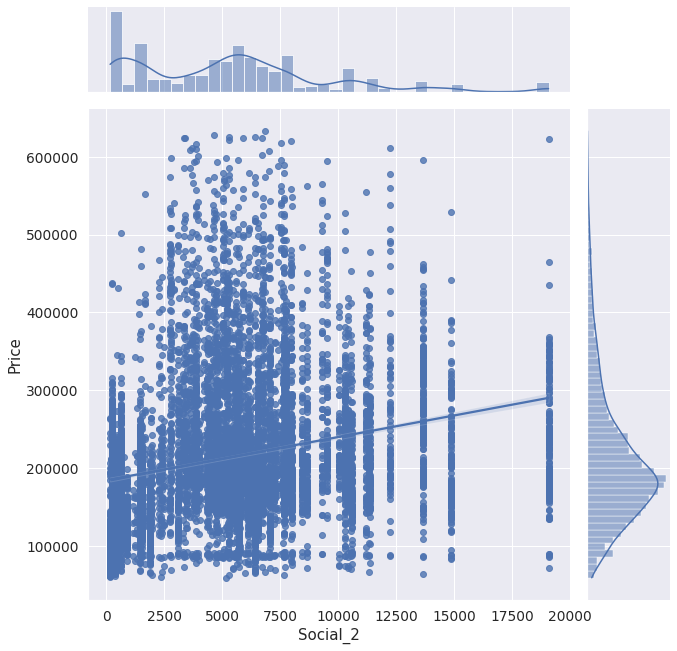

In [110]:
grid = sns.jointplot(train_df['Social_2'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)

plt.show()

In [111]:
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

Признак аналогичный Social_1. Также будем использовать частотное кодирование. Следует учесть сильную положительную корреляцию Social_1 и Social_2. Можно использовать алгоритм понижения размерности (PCA) и объединить эти признаки в один для преодоления проблемы мультиколинеарности. Или создать новые признаки (Target encoding) скомбинировав их с другими (комбо с целевой переменной).

##**Social_3**

In [112]:
train_df['Social_3'].value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
93       25
59       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

Для Social_3 требудется переход на частотное кодирование

##**Shops_1**

In [113]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

Для Shops_1 требудется переход на частотное кодирование

##**LifeSquare**


Заполним пропуски в переменной значением разницы между общей площадью и площадью кухни. Дополнительно вычтем 3 кв. метра(минимальная площадь на балконы, коридоры, кладовые)...

In [114]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [115]:
train_df.isna().sum()

Id                   0
DistrictId           0
Rooms                0
Square               0
LifeSquare           0
KitchenSquare        0
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1      4798
Helthcare_2          0
Shops_1              0
Shops_2              0
Price                0
Rooms_outlier        0
LifeSquare_nan       0
dtype: int64

##**KitchenSquare** (площадь кухни)

In [116]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

Согласно описательной статистике в выборке присутствуют объекты с явно завышенными (2014, 1970, 123, 112 и т.д ) или заниженными (1, 2 ) значениями площадей кухонь. Много объектов с нулевыми значениями. В итоге стандартное отклонение в четыре раза больше среднего значения. 
Для исправления ситуации создадим условие замены в данных: нулевые значения (нижнюю гарницу) обработаем вручную, а значения превышающие 0.95 квантиль заменим на медиану. Минимальным значением площади кухни примем 3 квадратных метра и заменим им значения в выборке >0, но <3 метров. 
После обработки мы наблюдаем перевес в сторону объектов с кухнями по 3 метра.

In [117]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [118]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [119]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.238200
std          2.794661
min          3.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

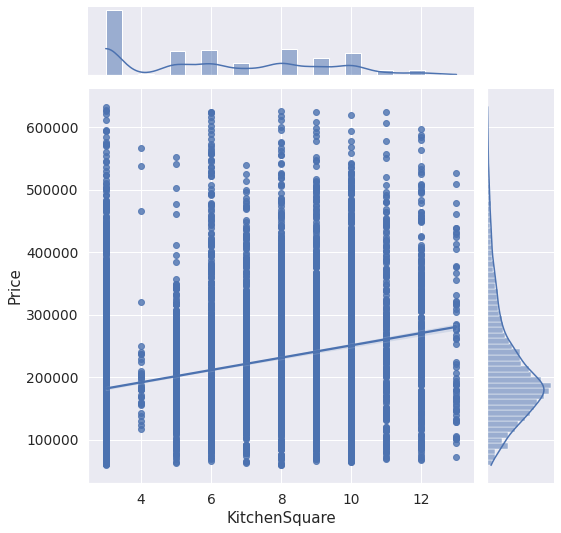

In [120]:
grid = sns.jointplot(train_df['KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

##**DistrictId**
 создадим новый признак с помощью частотного кодирования


In [121]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


##**Подготовка данных**
Заканчиваем предобработку данных оформлением класса и его функций.

В ходе тестирования моделей было принято решение не менять данные в признаке  Square и оставить признак  Healthcare_1

In [122]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""
        
        #Square
        #X['Square_outlier'] = 0
       # X.loc[(X['Square'] < 10) | (X['Square'] >= 400), 'Square_outlier'] = 1
        #X.loc[X['Square'] < 10, 'Square'] = self.medians['Square']
        #X.loc[X['Square'] >= 400, 'Square'] = self.medians['Square']
        
       
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
       # if 'Healthcare_1' in X.columns:
           # X.drop('Healthcare_1', axis=1, inplace=True)
         # Healthcare_1
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.medians['Healthcare_1']
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

##**Построение новых признаков**

Создаем признаки используя бинарное кодирование, частотное кодирование и Target encoding.
Тестируем вклад новых признаков и удаляем те, которые приводят к переобучению моделей (значимость более 50% ). 
Оформляем класс
**FeatureGenetator**


In [123]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_soc1_helt2 = None
        self.med_price_by_soc2_shops1 = None
        self.med_price_by_eco1_did = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.social_1_size = None
        self.social_2_size = None
        self.social_3_size = None
        self.helthcare_2_size = None
        self.shops_1_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        #задаем словарь для бинарного кодирования
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        #готовим матрицы перевода для частотного кодирования
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

        self.social_1_size = X['Social_1'].value_counts().reset_index() \
                               .rename(columns={'index':'Social_1', 'Social_1':'Social_1_size'})

        self.social_2_size = X['Social_2'].value_counts().reset_index() \
                               .rename(columns={'index':'Social_2', 'Social_2':'Social_2_size'})

        self.social_3_size = X['Social_3'].value_counts().reset_index() \
                               .rename(columns={'index':'Social_3', 'Social_3':'Social_3_size'})

        self.helthcare_2_size = X['Helthcare_2'].value_counts().reset_index() \
                               .rename(columns={'index':'Helthcare_2', 'Helthcare_2':'Helthcare_2_size'})

        self.shops_1_size = X['Shops_1'].value_counts().reset_index() \
                               .rename(columns={'index':'Shops_1', 'Shops_1':'Shops_1_size'})
                
        # Target encoding
        ## District, Rooms-переобучение
        #House_year, Social_3
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            #подготавливаем матрицу перевода для таргетэнкодинг(новые признаки комбо с целевой переменной)
            self.med_price_by_district = df.groupby(['Floor', 'Social_3'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()


            #рассчитываем медиану на новом признаке для дальнейшей замены возможных пропусков
            # (прописать эти два шага для моих новых признаков, каждый через новое условие)
            #self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

        ##Social_1, Healthcare_2*
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_soc1_helt2 = df.groupby(['Social_1', 'Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'Med_price_by_soc1_helt2'})

            self.med_price_by_soc1_helt2_median = self.med_price_by_soc1_helt2['Med_price_by_soc1_helt2'].median()

        ##Social_2, Shops_1
        if y is not None:
            df['Price'] = y.values  
            self.med_price_by_soc2_shops1 = df.groupby(['Social_2', 'Shops_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'Med_price_by_soc2_shops1'})

            self.med_price_by_soc2_shops1_median = self.med_price_by_soc2_shops1['Med_price_by_soc2_shops1'].median()


       ##Ecology_1, 'Healthcare_1'*
        if y is not None:
            df['Price'] = y.values  
            self.med_price_by_eco1_did = df.groupby(['Ecology_1', 'Healthcare_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'Med_price_by_eco1_did'})

            self.med_price_by_eco1_did_median = self.med_price_by_eco1_did['Med_price_by_eco1_did'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X = X.merge(self.social_1_size, on='Social_1', how='left')
        X = X.merge(self.social_2_size, on='Social_2', how='left')
        X = X.merge(self.social_3_size, on='Social_3', how='left')
        X = X.merge(self.helthcare_2_size, on='Helthcare_2', how='left')
        X = X.merge(self.shops_1_size, on='Shops_1', how='left')

#вводим новую переменную, чтобы пометить возможные новые пропуски и заполняем их в ней 1
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        #заполняем возможные новые пропуски после частотного кодирования каким-то числом(5)
        X['DistrictSize'].fillna(5, inplace=True)
        #создаем новую бинарную переменную по принципу большой (более 100) район или нет
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

        #Аналогичные операции делаем повсем признакам, для которых используем частотное кодирование
        'Social_1_size', 'Social_2_size', 'Social_3_size', 'Helthcare_2_size', 'Shops_1_size'
        X['new_social1'] = 0
        X.loc[X['Social_1_size'].isna(), 'new_social1'] = 1
        #заполняем возможные новые пропуски после частотного кодирования каким-то числом(5)
        X['Social_1_size'].fillna(5, inplace=True)
        #создаем новую бинарную переменную по принципу большой (более 100) район или нет
        X['IsSocial_1_Large'] = (X['Social_1_size'] > 100).astype(int)

        X['new_social2'] = 0
        X.loc[X['Social_2_size'].isna(), 'new_social2'] = 1
        #заполняем возможные новые пропуски после частотного кодирования каким-то числом(5)
        X['Social_2_size'].fillna(5, inplace=True)
        #создаем новую бинарную переменную по принципу большой (более 100) район или нет
        X['IsSocial_2_Large'] = (X['Social_2_size'] > 100).astype(int)
        
        X['new_social3'] = 0
        X.loc[X['Social_3_size'].isna(), 'new_social3'] = 1
        #заполняем возможные новые пропуски после частотного кодирования каким-то числом(5)
        X['Social_3_size'].fillna(5, inplace=True)
        #создаем новую бинарную переменную по принципу большой (более 100) район или нет
        X['IsSocial_3_Large'] = (X['Social_3_size'] > 200).astype(int)

        X['new_Helthcare2'] = 0
        X.loc[X['Helthcare_2_size'].isna(), 'new_Helthcare2'] = 1
        #заполняем возможные новые пропуски после частотного кодирования каким-то числом(5)
        X['Helthcare_2_size'].fillna(5, inplace=True)
        #создаем новую бинарную переменную по принципу большой (более 100) район или нет
        X['IsHelthcare_2_Large'] = (X['Helthcare_2_size'] > 100).astype(int)

        X['new_shops1'] = 0
        X.loc[X['Shops_1_size'].isna(), 'new_shops1'] = 1
        #заполняем возможные новые пропуски после частотного кодирования каким-то числом(5)
        X['Shops_1_size'].fillna(5, inplace=True)
        #создаем новую бинарную переменную по принципу большой (более 100) район или нет
        X['IsShops_1_Large'] = (X['Shops_1_size'] > 300).astype(int)


        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        #если заявленный признак посчитался в fit мы его присоединяем и пропуски заполняем медианами
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['Floor', 'Social_3'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
                 
        if self.med_price_by_soc1_helt2 is not None:
            X = X.merge(self.med_price_by_soc1_helt2, on=['Social_1', 'Helthcare_2'], how='left')
            X['Med_price_by_soc1_helt2'].fillna(self.med_price_by_soc1_helt2_median, inplace=True)
        
        if self.med_price_by_soc2_shops1 is not None:
            X = X.merge(self.med_price_by_soc2_shops1, on=['Social_2', 'Shops_1'], how='left')
            X['Med_price_by_soc2_shops1'].fillna(self.med_price_by_soc2_shops1_median, inplace=True)

        if self.med_price_by_eco1_did is not None:
            X = X.merge(self.med_price_by_eco1_did, on=['Ecology_1', 'Healthcare_1'], how='left')
            X['Med_price_by_eco1_did'].fillna(self.med_price_by_eco1_did_median, inplace=True)   
                   
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

##**Переходим к этапу отбора признаков**
В финальную модель были включены признаки, значимость которых более 0,001%, исключены дополнительные признаки, приводящие к переобучению моделей.

In [124]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Healthcare_1', 'Social_1'] 

new_feature_names = [ 'Healthcare_1_nan','DistrictSize', 'IsDistrictLarge','Social_2_size',
                        
                      'Social_3_size',  'Helthcare_2_size',
                     'Shops_1_size', 'Med_price_by_eco1_did', 'Med_price_by_soc1_helt2']

target_name = 'Price'

На данном наборе признаков были протестированы следующие модели:
1. rf_model = **RandomForestRegressor**(criterion='mse', random_state=42,
                                 n_estimators=400,  # кол-во деревьев
                                 max_features=10, min_samples_leaf=2,
                                 min_samples_split= 6, bootstrap= True)


2. lgbm_regressor_model = **LGBMRegressor**(max_bin=255, num_leaves=4,     n_estimators=4000,max_depth = 10, learning_rate=0.02, max_features = 19, min_samples_split = 3,loss = 'huber', alpha=0.95)


3. gb_model = **GradientBoostingRegressor**(criterion='mse',
                                     max_depth=3,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)


4. clf = **ensemble.GradientBoostingRegressor**(n_estimators = 170, max_depth = 5, min_samples_split = 9,
          learning_rate = 0.1, loss = 'huber', alpha=0.95, max_features = 9,
           min_impurity_decrease=0.01, warm_start= True, n_iter_no_change=10, random_state=42)

5. hclf = **ensemble.HistGradientBoostingRegressor**(loss='squared_error', learning_rate=0.1, max_iter=200, max_leaf_nodes=100, max_depth=5,           min_samples_leaf=20, l2_regularization=0.1,                          max_bins=255, сategorical_features=None,                                              monotonic_cst=None, warm_start=True, early_stopping='auto',
                                              scoring='loss', validation_fraction=0.2, n_iter_no_change=10,
                                              tol=1e-07, verbose=0, random_state=42)

Лучшие результаты показала модель **clf**
Согласно рекомендации преподавателя (не использовать градиентный бустинг, а предпочтительнее  **RandomForestRegressor** , приводятся результаты работы  RF модели.

In [125]:
#Разбиение на train и test
train_df = pd.read_csv('train.csv', sep=',')
test_df = pd.read_csv('test.csv', sep=',')

In [126]:
#train_df = train_df[train_df['Price']  < 60000]
#train_df['Price'] = np.log1p(train_df['Price'])

In [127]:
X = train_df.drop(columns = target_name)
y = train_df[target_name]

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [129]:


preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape
#23 это количество признаков

((6700, 24), (3300, 24), (5000, 24))

In [130]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape
#35 это количество признаков, должно быть одинаковое число на всех выборках!

((6700, 49), (3300, 49), (5000, 49))

In [131]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [132]:
# проверка на пропуски после обработки данных и генерации новых признаков

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()



(0, 0, 0)

In [133]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.916
RMSE:	26744.424
MSE:	715264234.933


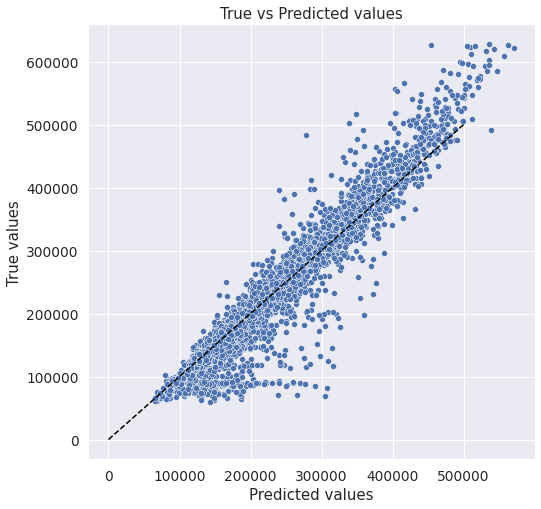

In [143]:
rf_model = RandomForestRegressor(criterion='mse', random_state=42,
                          n_estimators=350,  # кол-во деревьев
                          max_features=10, min_samples_leaf=2,
                          min_samples_split= 6, bootstrap= True)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.759
RMSE:	45969.73
MSE:	2113216066.72


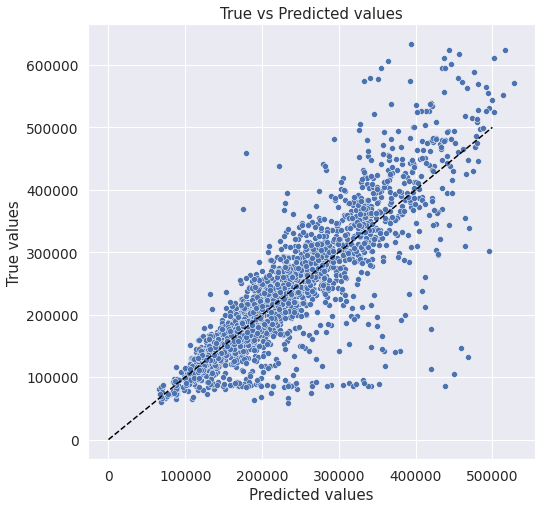

In [144]:
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

In [136]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score



array([0.73787567, 0.69942025, 0.72781524])

In [137]:
cv_score.mean()



0.7217037190580914

In [138]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.326259
17,Med_price_by_eco1_did,0.163918
0,Rooms,0.117593
18,Med_price_by_soc1_helt2,0.083830
11,DistrictSize,0.068042
2,LifeSquare,0.056829
6,HouseYear,0.029675
14,Social_3_size,0.019367
3,KitchenSquare,0.018414
5,HouseFloor,0.018072


In [139]:
submit = pd.read_csv('sample_submission.csv', sep=',')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [140]:
predictions = rf_model.predict(test_df)
predictions

array([156073.88073635, 118074.99548331, 137687.79680621, ...,
       147752.72228686, 192283.66045982, 239396.87259762])

In [141]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,156073.880736
1,5925,118074.995483
2,960,137687.796806
3,3848,117173.426631
4,746,197106.912171


In [142]:
submit.to_csv('Malkova_prediction.csv', index=False)

##**Кросс-валидация** выбранной модели- поиск лучших параметров.
Для экономии времени отработки ноутбука этот этап приводится только в текстовом формате. Ниже представлен полный перечень, проверенных параметров модели.


params = {'min_samples_split':[6, 9, 11], 
          'max_features':[10, 5, 7],
          'max_depth':[4, 5, 6],
          'n_estimators':[400, 800, 1000]}  # кол-во деревьев
                         

gs_rf = GridSearchCV(rf_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )